In [148]:
import torch
import numpy as np
import os
import os.path as osp
import pandas as pd
import re
import seaborn as sns
import sys
import time
from tqdm.autonotebook import tqdm
import matplotlib.pylab as plt
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from collections import defaultdict

sys.path.append('../..')

## Imports based on our ready-to-use code (after you pip-install the cs233_gtda_hw4 package)
from cs233_gtda_hw4.in_out.utils import make_data_loaders
from cs233_gtda_hw4.in_out.utils import save_state_dicts, load_state_dicts
from cs233_gtda_hw4.in_out import pointcloud_dataset
from cs233_gtda_hw4.in_out.plotting import plot_3d_point_cloud

from cs233_gtda_hw4.losses import EncodingDistance

## Imports you might use if you follow are scaffold code (it is OK to use your own stucture of the models)
from cs233_gtda_hw4.models import FancyPartAwarePointcloudAutoencoder
from cs233_gtda_hw4.models.point_net import PointNet
from cs233_gtda_hw4.models.mlp import MLP

from collections import defaultdict
from sklearn.neighbors import NearestNeighbors  # Students: you can use this implementation to find the 
                                                # Nearest-Neigbors
from tensorboard.backend.event_processing import event_accumulator
    
from cs233_gtda_hw4.losses import EncodingDistance

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# ANALYZE ALL MODELS

In [149]:
default_params = {
    'out_n': 1024,
    'drop': 0,
    'bnorm': False,
    'noise': 0,
    'alpha': 0,
    'encode_parts': False,
    'predict_parts': False,
    'penal_parts': False,
    'predict_part_exist': False,
    'variational': False,
    'hdim': 128,
}

def parse_tensorboard(path, scalars, return_all=False):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    # try:
    #     assert all(
    #         s in ea.Tags()["scalars"] for s in scalars
    #     ), "some scalars were not found in the event accumulator"
    # except:
    #     return {}
    
    res = {}
    if return_all:
        for k in scalars:
            try:
                res[k] = [s.value for s in ea.Scalars(k)]        
            except:
                continue
        res['step'] = [s.step for s in ea.Scalars('Loss/recon/test')] 
    else:
        for k in scalars:
            try:
                res[k] = ea.Scalars(k)[-1].value
            except:
                continue
        try:
            res['step'] = ea.Scalars('Loss/recon/test')[-1].step
        except:
            pass
    return res

def parse_model_params(model_tag):
    res = {}
    
    if 'pc_ae' in model_tag:
        res = default_params
        if model_tag.startswith('part_pc_ae'):
            res['predict_parts'] = True
        return res
    
    res['out_n'] = int(re.match(r'.*outn([\d|\.|e|-]+)_.*', model_tag).group(1))
    res['drop'] = float(re.match(r'.*drop([\d|\.|e|-]+)_.*', model_tag).group(1))
    res['bnorm'] = 'bnorm' in model_tag
    res['noise'] = float(re.match(r'.*noisy([\d|\.|e|-]+)_.*', model_tag).group(1))
    res['alpha'] = float(re.match(r'.*alpha([\d|\.|e|-]+)_.*', model_tag).group(1))
    
    res['encode_parts'] = 'encpts' in model_tag
    
    res['predict_parts'] = 'predpts' in model_tag
    if res['predict_parts']: 
        res['part_lambda'] = float(re.match(r'.*predpts([\d|\.|e|-]+)_.*', model_tag).group(1))
        res['cdec'] = float(re.match(r'.*cdec([\d|\.|e|-]+)_.*', model_tag).group(1))
        
    try:
        res['penal_parts'] = float(re.match(r'.*penpts([\d|\.|e|-]+)_.*', model_tag).group(1))
    except AttributeError:
        pass
    
    res['predict_part_exist'] = 'predex' in model_tag
    if res['predict_part_exist']: res['exist_lambda'] = float(re.match(r'.*predex([\d|\.|e|-]+)_.*', model_tag).group(1))
    
    res['variational'] = 'var' in model_tag
    if res['variational']: 
        res['kl_lambda'] = float(re.match(r'.*kl([\d|\.|e|-]+)_.*', model_tag).group(1))
        res['kdec'] = float(re.match(r'.*kdec([\d|\.|e|-]+)_.*', model_tag).group(1))
    try:
        res['hdim'] = int(re.match(r'.*hdim([\d|\.|e|-]+)_.*', model_tag).group(1))
    except AttributeError:
        res['hdim'] = 128
    return res

def parse_model(tagtime):
    scalars = [f'Loss/{t}/test' for t in ['enc', 'xentr', 'bce', 'kl', 'recon', 'total']]

    data = parse_tensorboard(f'../data/logs/{tagtime}', scalars)
    if len(data) == 0:
        return data
    data = data | parse_model_params(tagtime)
    data['tagtime'] = tagtime
    return data



In [150]:
tb_data = []
for tag in os.listdir('../data/logs'):
    if tag.split('_')[-1] >= '20240312':
        data = parse_model(tag)
        if len(data) > 0:
            tb_data.append(data)

In [151]:
tb_data = pd.DataFrame(tb_data)
tb_data = tb_data[(tb_data.step >= 400) & (tb_data.tagtime != 'exp_outn256_hdim128_drop0.0_bnorm_kl1e-05_noisy0.005_cdec0.7_alpha1e-06_kdec1.15_predpts0.0005_predex0.005_encpts_var_20240312-013148')]

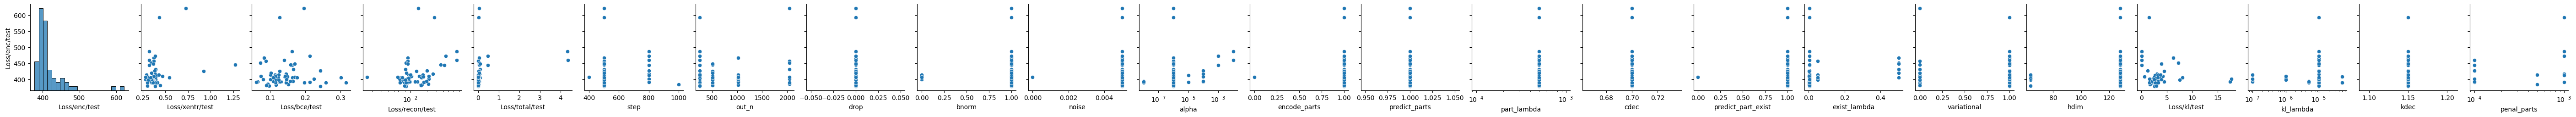

In [152]:
import seaborn as sns
g = sns.pairplot(tb_data,
             # x_vars=[s for s in tb_data.columns if not s.startswith('Loss')],
             y_vars=['Loss/enc/test'])

log_columns = ['part_lambda', 'kl_lambda', 'exist_labmda', 'penal_parts', 'alpha', 'Loss/recon/test']
for ax in g.axes.flat:
    if ax.get_xlabel() in log_columns:
        ax.set(xscale="log")

# BEST MODEL

In [201]:
best_model = tb_data.sort_values('Loss/enc/test', ascending=True).iloc[0].tagtime

In [202]:
## EDIT HERE FOR DIFFERENT MODELS
# print(tb_data[tb_data.tagtime==best_model].T.to_latex())
hypers = [
    'out_n',
    'drop',              
    'bnorm',             
    'noise',             
    'alpha',             
    'encode_parts',
    'predict_parts' ,   
    'part_lambda' ,     
    'cdec',        
    'predict_part_exist',
    'exist_lambda',
    'variational',  
    'hdim',         
    'kl_lambda',      
    'kdec',     
    'penal_parts',   
]

tb_data[tb_data.tagtime==best_model][['tagtime'] + hypers].T

,33
tagtime,exp_outn256_hdim128_drop0.0_bnorm_kl1e-05_nois...
out_n,256
drop,0.0
bnorm,True
noise,0.005
alpha,0.000001
encode_parts,True
predict_parts,True
part_lambda,0.0005
cdec,0.7


Text(5.069444444444445, 0.5, 'Encoding Distance')

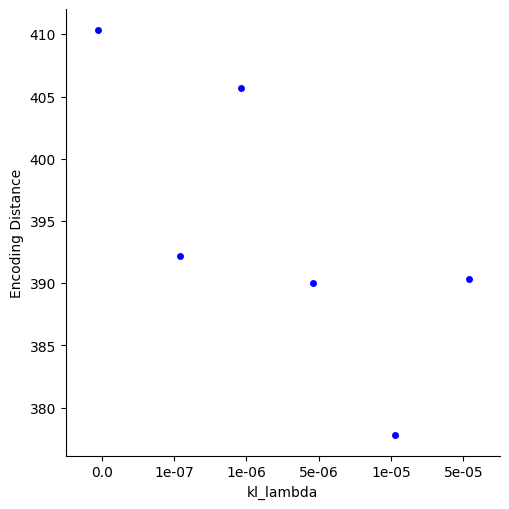

In [203]:
def get_similar(tag, exc):
    idx = np.all(np.array(
        [tb_data[h].fillna(0)==tb_data[tb_data.tagtime==best_model][h].fillna(0).values.item() for h in hypers if h not in exc]), axis=0)
    return tb_data[idx]

# 'predict_part_exist', 'exist_lambda'
exc = ['kl_lambda', 'variational', 'kdec']
sns.catplot(data=get_similar(best_model, exc).fillna(0),
            x='kl_lambda',
            y='Loss/enc/test',
            color='b'
           )
plt.ylabel('Encoding Distance')
# plt.xscale('log')

# get_similar(best_model, exc).T

# SPECIFIC MODEL

In [211]:
#'exp_outn256_hdim128_drop0.0_bnorm_kl1e-05_noisy0.005_cdec0.7_alpha1e-06_kdec1.15_predpts0.0005_penpts0.0005_predex0.005_encpts_var_'
tagtime = best_model # 'part_pc_ae_out1024_20240312-185502'# 'pc_ae_out1024_20240311-062551' 
model_tag = '_'.join(tagtime.split('_')[:-1])

##
## Fixed Settings (we do not expect you to change these)
## 

n_points = 1024  # number of points of each point-cloud
n_parts = 4      # max number of parts of each shape
n_train_epochs = 600 #400

# Students: feel free to change below -ONLY- for the bonus Question:
# I.e., use THESE hyper-parameters when you train for the non-bonus questions.

## Students: feel free to change below:

# batch-size of data loaders
batch_size = 128 # if you can keep this too as is keep it, 
                 # but if it is too big for your GPU, feel free to change it.

# which device to use: cpu or cuda?

# device = 'cpu'     # Note: only the "alternative" (slower) chamfer_loss in losses/nn_distance can run in cpu.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

top_in_dir = '../data/'
top_out_dir = '../data/out/'
if not osp.exists(top_out_dir):
    os.makedirs(top_out_dir)
    
top_log_dir = '../data/logs/'
if not osp.exists(top_log_dir):
    os.makedirs(top_log_dir)

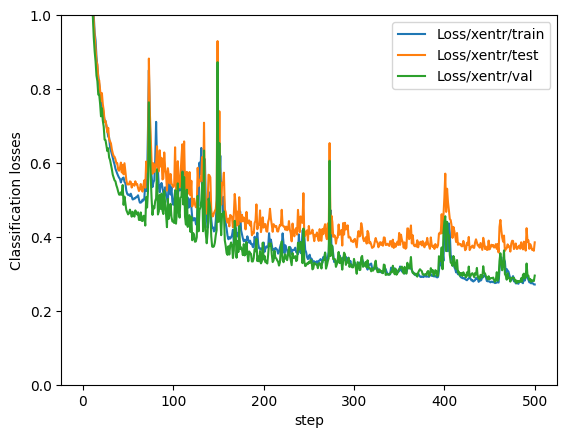

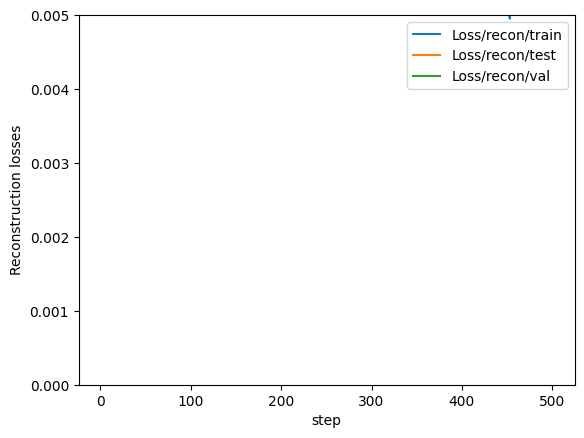

In [212]:
losses = [f'Loss/xentr/{p}' for p in ['train', 'test', 'val']]
loss_df = pd.DataFrame(parse_tensorboard(f'../data/logs/{tagtime}', losses, return_all=True))
for loss in losses:
    ax = sns.lineplot(data=loss_df, x='step', y=loss, label=loss)
ax.set_yscale('linear')
ax.set_ylim(0, 1)
ax.set_ylabel('Classification losses')
plt.show()

losses = [f'Loss/recon/{p}' for p in ['train', 'test', 'val']]
loss_df = pd.DataFrame(parse_tensorboard(f'../data/logs/{tagtime}', losses, return_all=True))
for loss in losses:
    ax = sns.lineplot(data=loss_df, x='step', y=loss, label=loss)
ax.set_yscale('linear')
ax.set_ylim(0, 0.005)
ax.set_ylabel('Reconstruction losses')
plt.show()

In [213]:
for loss in losses:
    print(f'Lowest {loss} at step {loss_df[loss].argmin()+1}: {loss_df[loss].min():.2e}')

Lowest Loss/recon/train at step 453: 4.95e-03
Lowest Loss/recon/test at step 455: 8.04e-03
Lowest Loss/recon/val at step 455: 7.02e-03


In [226]:
# PREPARE DATA:
import re
loaders = make_data_loaders(top_in_dir, batch_size)

for split, loader in loaders.items():
    print('N-examples', split, len(loader.dataset))
    
    
# BUILD MODELS:
### TODO: Student on your own:
model_params = defaultdict(int, parse_model_params(model_tag))
out_n = model_params['out_n']
drop = model_params['drop']
bnorm = model_params['bnorm']
noise = model_params['noise']
alpha = model_params['alpha']
cdec = model_params['cdec']
part_lambda = model_params['part_lambda']
exist_lambda = model_params['exist_lambda']
kl_lambda = model_params['kl_lambda']
kdec = model_params['kdec']
encode_parts = model_params['encode_parts']
predict_parts = model_params['predict_parts']
penal_parts = model_params['penal_parts']
predict_part_exist = model_params['predict_part_exist']
variational = model_params['variational']

hdim = model_params['hdim']

encoder = PointNet(conv_dims=[32, 64, 64, 128, hdim * (2 if variational else 1)])
decoder = MLP(hdim, [256, 384, out_n*3], b_norm=bnorm, dropout_rate=drop)
part_classifier = PointNet(hdim+3, [64, n_parts], max_pool=False)
part_exister = MLP(hdim, [64, n_parts])  # MLP(hdim, [64, 64, n_parts])

N-examples train 750
N-examples test 150
N-examples val 50


In [227]:
part_aware_model = predict_parts

model = FancyPartAwarePointcloudAutoencoder(
    encoder, decoder, part_classifier, part_exister,
    part_lambda=part_lambda, device=device, class_decay=cdec, decode_alpha=alpha,
    variational=variational, kl_lambda=kl_lambda, exist_lambda=exist_lambda, noise=noise,
    kl_decay=kdec, encode_parts=encode_parts, predict_parts=predict_parts, penal_parts=penal_parts,
    predict_part_exist=predict_part_exist).to(device) # Students Work here

out_file = osp.join(top_out_dir, model_tag + '_best_model.pth')

In [241]:
# Load model with best per-validation loss (uncomment when ready)
best_epoch = load_state_dicts(out_file, model=model, map_location=torch.device(device))
print('per-validation optimal epoch', best_epoch)

per-validation optimal epoch 17


# PLOTTING

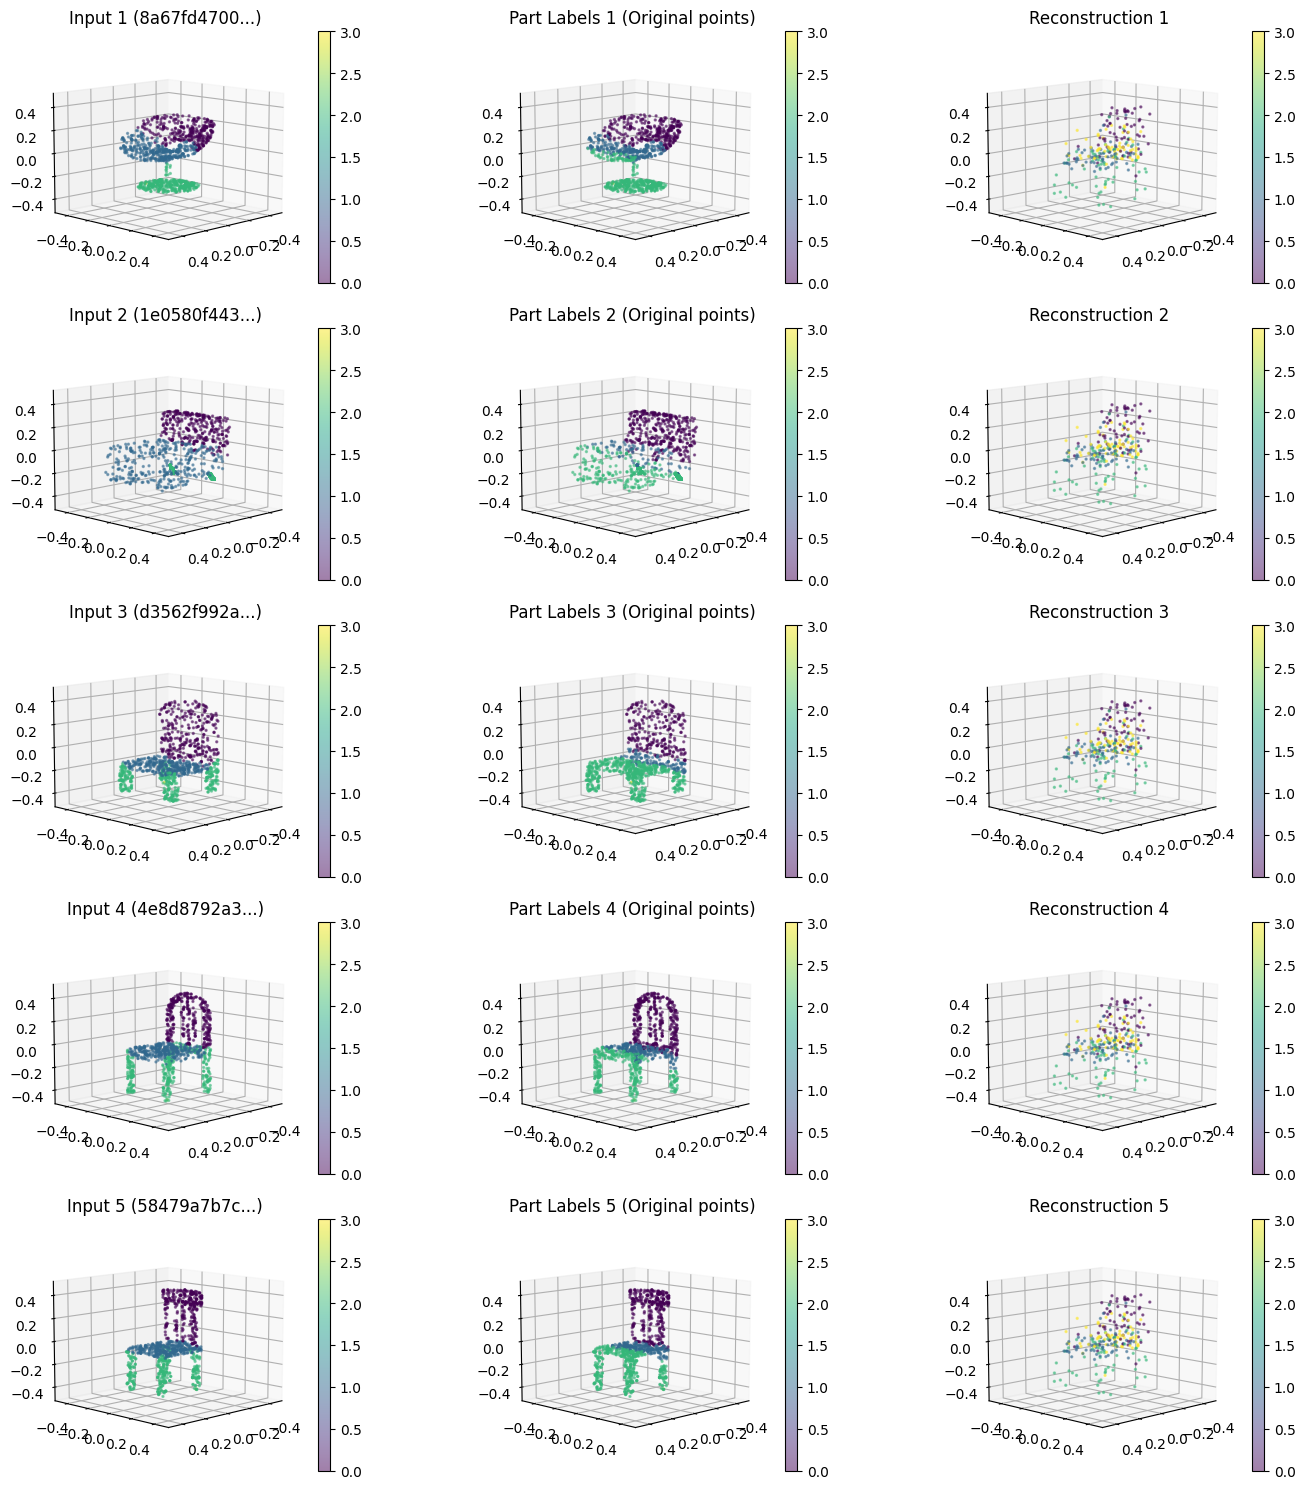

In [192]:
# Students TODO: MAKE your plots and analysis

# 5 examples to visualize per questions (e, f)
examples_to_visualize = ['8a67fd47001e52414c350d7ea5fe2a3a',
                         '1e0580f443a9e6d2593ebeeedbff73b',
                         'd3562f992aa405b214b1fd95dbca05',
                         '4e8d8792a3a6390b36b0f2a1430e993a',
                         '58479a7b7c157865e68f66efebc71317']

# You can (also) use the function for the reconstructions or the part-predictions 
# (for the latter check the kwargs parameter 'c' of matplotlib.
    # plot_3d_point_cloud, eg. try plot_3d_point_cloud(loaders['test'].dataset.pointclouds[0])
part_aware_model=True
def plot_examples(examples_to_visualize, show=True):
    model.eval()   # Do not forget this.! We are not training any more (OK, since we do not 
                   # have batch-norm, drop-out etc. this is not so important, however it is good standard 
                   # practice)

    n_cols = 3 if part_aware_model else 2
    fig = plt.figure(figsize=(5 * n_cols, 3 * len(examples_to_visualize)))
    for i, ex in enumerate(examples_to_visualize):
        for l in loaders['test']:
            if ex in l['model_name']:
                for j in range(len(l['model_name'])):
                    if l['model_name'][j] == ex:
                        pc = l['point_cloud'][j]
                        tl = l['part_mask'][j]
        for k in range(4):
            if k not in tl:
                tl[k] = k
        ax1 = fig.add_subplot(len(examples_to_visualize), n_cols, n_cols*i+1, projection='3d')
        # pc should contain correct point cloud
        plot_3d_point_cloud(pc, axis=ax1, c=tl, show=False, alpha=0.5, show_axis=True, label='Input', 
                            title=f'Input {i+1} ({ex[:10]}...)')

        ax2 = fig.add_subplot(len(examples_to_visualize), n_cols, n_cols*i+2, projection='3d')
        
        recon, labels, loss = model.reconstruct_single(pc, tl, device)
        if model.predict_parts:
            labels = labels.squeeze(0)
            for k in range(4):
                if k not in labels:
                    labels[k] = k
            
            plot_3d_point_cloud(pc.cpu(), axis=ax2, c=labels.cpu(), show=False, alpha=0.5, show_axis=True, 
                            label='Reconstruction', title=f'Part Labels {i+1} (Original points)')

            ax3 = fig.add_subplot(len(examples_to_visualize), n_cols, n_cols*i+3, projection='3d')
            part_n = out_n // 4
            color = np.array([0] * part_n + [1] * part_n + [2] * part_n + [3] * part_n) if model.encode_parts else 'r'
            plot_3d_point_cloud(recon.cpu(), axis=ax3, c=color, show=False, alpha=0.5, show_axis=True, 
                            label='Reconstruction', title=f'Reconstruction {i+1}')
        else:
            color = np.array([0] * part_n + [1] * part_n + [2] * part_n + [3] * part_n) if model.encode_parts else 'r'
            plot_3d_point_cloud(recon.cpu(), axis=ax2, c=color, show=False, alpha=0.5, show_axis=True, 
                            label='Reconstruction', title=f'Visualization {i+1} ')

    plt.tight_layout()
    if show:
        plt.show()
    else:
        return fig
    
plot_examples(examples_to_visualize)

Segmentation accuracy: 70.54%


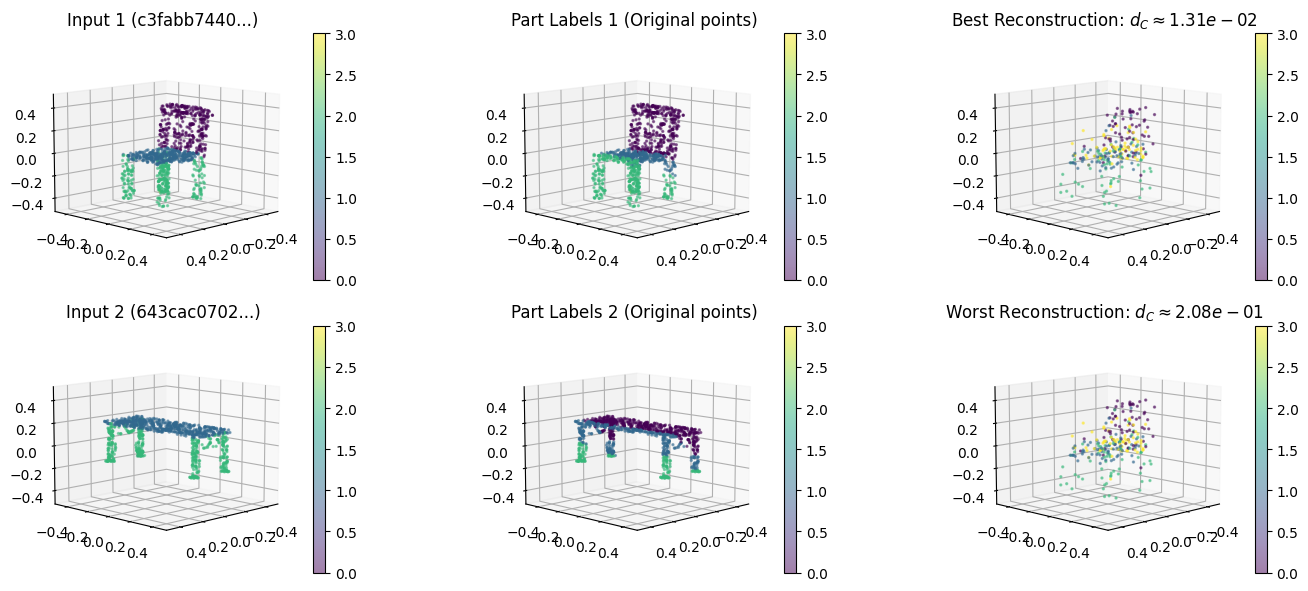

In [187]:
# Plot best and worst reconstructions
# for l in loaders['test']:
#     pc = l['point_cloud']

out = model.reconstruct(loaders['test'], device, return_all_recon_loss=True)
recons, labels, recon_losses = out[0], out[1], out[-1]
recon_losses = [r.item() for r in recon_losses]

# best reconstruction
best_idx = np.argmin(recon_losses)
best_model = list(loaders['test'])[best_idx // batch_size]['model_name'][best_idx % batch_size]

# worst reconstruction
worst_idx = np.argmax(recon_losses)
worst_model = list(loaders['test'])[worst_idx // batch_size]['model_name'][worst_idx % batch_size]

fig = plot_examples([best_model, worst_model], show=False)
fig.get_axes()[4 if model.predict_parts else 2].set_title(f'Best Reconstruction: $d_C \\approx {min(recon_losses):.2e}$')
fig.get_axes()[10 if model.predict_parts else 6].set_title(f'Worst Reconstruction: $d_C \\approx {max(recon_losses):.2e}$')

if model.predict_parts:
    true_labels = []
    for l in loaders['test']:
        true_labels.append(l['part_mask'])
    true_labels = torch.concat(true_labels)
    acc = (true_labels == labels.argmax(1)).float().mean()
    print(f'Segmentation accuracy: {acc * 100:.2f}%')

# PART AWARE DISTANCES

In [179]:
# Load golden distances (pairwise matrix, or corresponding model/part names in golden_names)
golden_part_dist_file = '../data/golden_dists.npz'
golden_data = np.load(golden_part_dist_file, allow_pickle=True)
golden_part_dist = golden_data['golden_part_dist']
golden_names = golden_data['golden_names']
  
# Load/organize golden part-aware distances.
sn_id_to_parts = defaultdict(list)
id_to_part_loc = dict()

for i, name in enumerate(golden_names):
    # Extract shape-net model ids of golden, map them to their parts.
    sn_id, _, part_id, _, _ = name.split('_')
    sn_id_to_parts[sn_id].append(part_id)
    
    # Map shape-net model id and part_id to location in distance matrix, (the order is the same).
    id_to_part_loc[(sn_id, part_id)] = i
    
enc_dist = EncodingDistance('../data/golden_dists.npz')
def measure_part_awareness(model_tag, return_df=False):
    if model_tag != 'random':
        ae_emb_file = f'../data/out/{model_tag}_latent_codes.npz'
        in_d = np.load(ae_emb_file)

        latent_codes = in_d['latent_codes']
        test_names = in_d['test_names']
    else:
        latent_codes = np.random.rand(len(test_names), 123)

    res = enc_dist.calculate(latent_codes, test_names, return_df)
    
    if return_df:
        return res
    
    res['model_tag'] = model_tag
    return res

In [17]:
# BEST POSSIBLE PART DISTANCES
ae_emb_file = f'../data/out/{model_tag}_latent_codes.npz'
in_d = np.load(ae_emb_file)

latent_codes = in_d['latent_codes']
test_names = in_d['test_names']
encoding_distances = np.zeros(len(test_names))

data = []
for i, sn_name in enumerate(test_names):
    parts_of_model = set(sn_id_to_parts[sn_name])

    min_distance = np.inf
    # greedily search for the best possible match
    for matched_neighbor in test_names:
        if matched_neighbor == sn_name:
            continue
        distance = 0
        parts_of_neighbor = set(sn_id_to_parts[matched_neighbor])

        # compute the requested distances.
        # Use id_to_part_loc for each model/part combination
        parts_in_both = parts_of_model.intersection(parts_of_neighbor)
        for k in parts_in_both:
            distance += golden_part_dist[id_to_part_loc[(sn_name, k)], id_to_part_loc[(matched_neighbor, k)]]

        parts_only_model = parts_of_model.difference(parts_of_neighbor)
        parts_only_neighbor = parts_of_neighbor.difference(parts_of_model)
        # for k in parts_only_A:
        #     distance += max([golden_part_dist[id_to_part_loc[(matched_neighbor, k)], id_to_part_loc[(sn_name, u)]] for u in parts_of_model])

        # part distance as in homework
        cand_distances = [0] * 4
        for u in parts_of_model:
            for k in parts_only_neighbor:
                cand_distances[int(u) - 1] += golden_part_dist[
                    id_to_part_loc[(matched_neighbor, k)], id_to_part_loc[(sn_name, u)]]
        distance += max(cand_distances)
        
        if distance < min_distance:
            min_distance = distance
            best_neighbor = matched_neighbor
    encoding_distances[i] = min_distance
    data.append({'name': sn_name, 'match': best_neighbor, 'dist': min_distance})

print(f'''
    IDEAL PART AWARENESS: \n
    Cumulative encoding distance = {encoding_distances.sum():.4f}
''')

ideal_matches = pd.DataFrame(data)


    IDEAL PART AWARENESS: 

    Cumulative encoding distance = 322.3948



In [21]:
pd.DataFrame([measure_part_awareness('pc_ae_out1024'),
measure_part_awareness('part_pc_ae_out1024')])

,enc_dist,shared_pts,latent_dist,model_tag
0,419.535706,3.16,0.226930,pc_ae_out1024
1,411.293151,3.16,0.263976,part_pc_ae_out1024


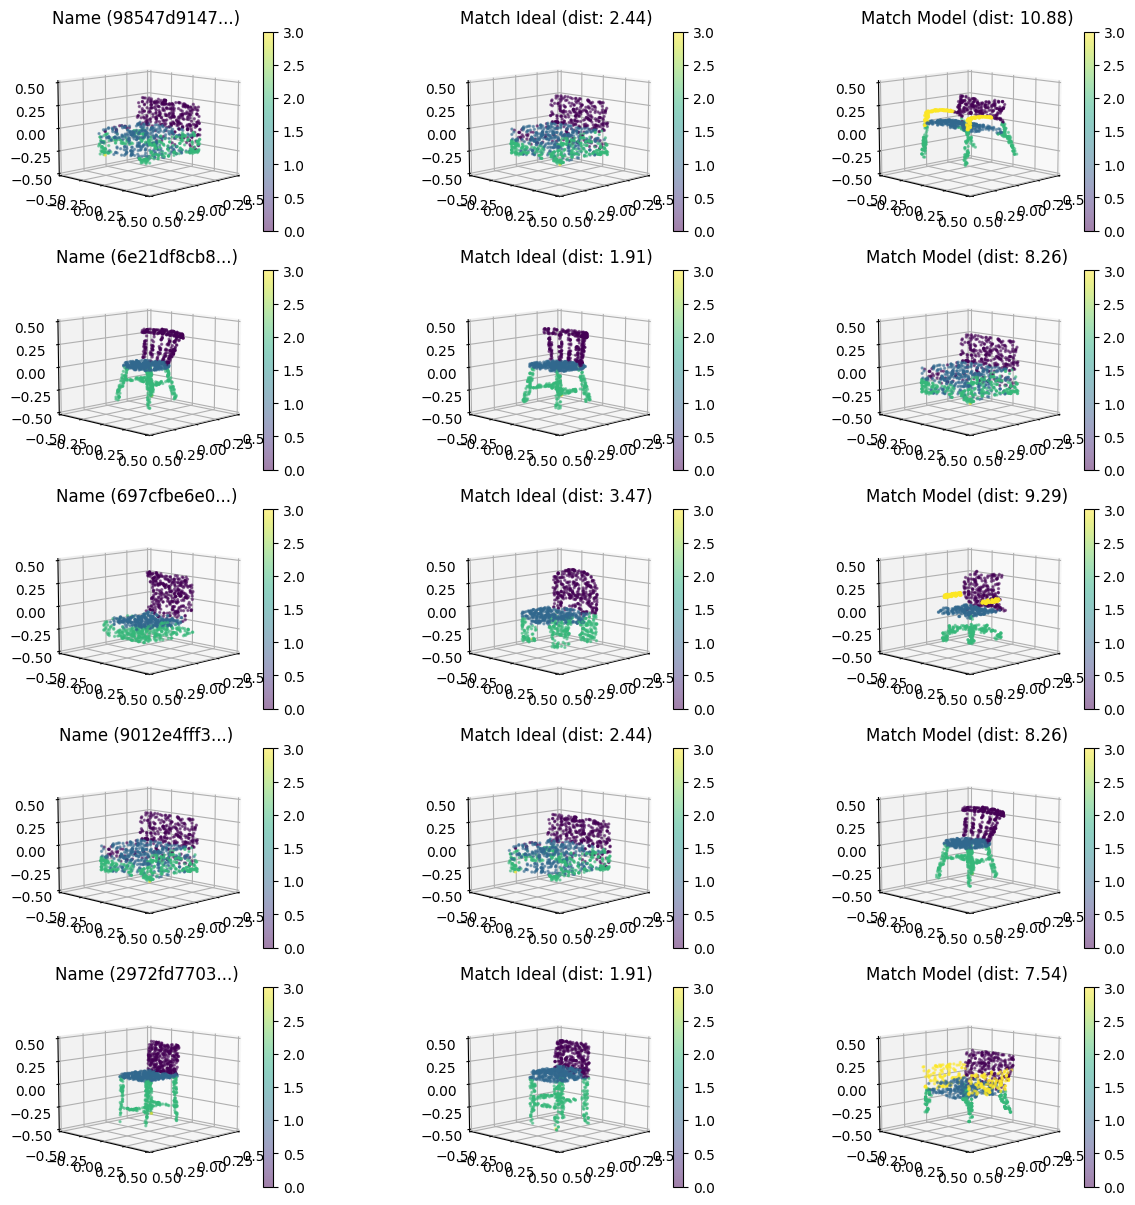

In [191]:
model_matches = measure_part_awareness(model_tag, return_df=True)

match_df = model_matches.merge(ideal_matches, on=['name'], suffixes=('_model', '_ideal'))
match_df['delta_dist'] = match_df.dist_model - match_df.dist_ideal
match_df = match_df.sort_values('delta_dist', ascending=False)

k = 5
fig = plt.figure(figsize=(15, 3 * k))
for i, (_, row) in enumerate(match_df[:k].iterrows()):
    for jj, mstr in enumerate(['name', 'match_ideal', 'match_model']):
        ex = row[mstr]
        for l in loaders['test']:
            if ex in l['model_name']:
                for j in range(len(l['model_name'])):
                    if l['model_name'][j] == ex:
                        pc = l['point_cloud'][j]
                        tl = l['part_mask'][j]
                        break

        for kk in range(4):
            if kk not in tl:
                tl[k] = kk
        ax = fig.add_subplot(k, 3, 3*i+1 +jj, projection='3d')
        
        title = ' '.join([s.title() for s in mstr.split('_')])
        if mstr=='name':
            title += f' ({ex[:10]}...)'
        elif mstr=='match_ideal':
            title += f' (dist: {row["dist_ideal"]:.2f})'
        else:
            title += f' (dist: {row["dist_model"]:.2f})'
        # pc should contain correct point cloud
        plot_3d_point_cloud(pc, axis=ax, c=tl, show=False, alpha=0.5, show_axis=True, label='Chair A', 
                            title=title)

# SAVE LATENTS

In [190]:
# Last, save the latent codes of the test data and go to the 
# measuring_part_awareness and tsne_plot_with_latent_codes code.

model.eval()
latent_codes = []
test_names = []
for load in loaders['test']:
    pointclouds = load['point_cloud']
    test_names += load['model_name']
    latent_codes += [l.cpu().numpy() for l in model.embed(pointclouds.to(device))]
    
latent_codes = np.array(latent_codes)

# Students TODO: Extract the latent codes and save them, so you can analyze them later.
np.savez(osp.join(top_out_dir, model_tag +'_latent_codes'), 
         latent_codes=latent_codes, 
         test_names=test_names)